## WeGo Data Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

wego.head(100)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,120230801,1,99457985,2023-08-01,22,2200,2689,345132,0,FROM DOWNTOWN,...,36.800000,6.800000,0,0,1,0,0.0,0,0.000000,NaN
96,120230801,1,99457986,2023-08-01,22,2200,2689,345132,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
97,120230801,1,99457987,2023-08-01,22,2200,2689,345133,0,TO DOWNTOWN,...,60.533333,-7.466667,0,0,1,0,0.0,0,1.733333,7.0
98,120230801,1,99457988,2023-08-01,22,2200,2689,345133,0,TO DOWNTOWN,...,35.750000,2.750000,0,0,1,0,0.0,0,0.000000,NaN


In [3]:
wego.shape                                                                             

(350329, 30)

In [4]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

In the data, the bus route can be identified by its ROUTE_ABBR value.  
**3:** West End  
**7:** Hillsboro  
**22:** Bordeaux  
**23:** Dickerson Pike  
**50:** Charlotte Pike  
**52:** Nolensville Pike  
**55:** Murfreesboro Pike  
**56:** Gallatin Pike

In [5]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

The trip can be identified by the DATE/CALENDAR_ID plus the TRIP_ID.  
**Warning:** The TRIP_ID refers to the route and time but will be used across multiple days.

The data contains multiple **time points** for each trip. There are more stops along the route than time points, but the time points are the points with specific scheduled times the bus operators must adhere to.

The first stop of a trip has a TRIP_EDGE of 1, the last has a TRIP_EDGE of 2, and the intermediate stops are TRIP_EDGE 0. 

Here is the first trip in the dataset. It was a Bordeaux route (Route 22), scheduled to start at 4:42:00 and end at 5:10:00.

In [6]:
wego[['DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'SCHEDULED_TIME']].loc[:3]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00


Note that the same TRIP_ID appears on the following day.

In [7]:
(
    wego
    .loc[wego['DATE'].astype(str).isin(['2023-08-01', '2023-08-02'])]
    .loc[wego['TRIP_ID'] == 345104]
    [['DATE', 'ROUTE_ABBR', 'TRIP_ID', 'TIME_POINT_ABBR', 'TRIP_EDGE', 'ROUTE_DIRECTION_NAME', 'SCHEDULED_TIME', 'ROUTE_STOP_SEQUENCE']]
)

,DATE,ROUTE_ABBR,TRIP_ID,TIME_POINT_ABBR,TRIP_EDGE,ROUTE_DIRECTION_NAME,SCHEDULED_TIME,ROUTE_STOP_SEQUENCE
0,2023-08-01,22,345104,MHSP,1,TO DOWNTOWN,2023-08-01 04:42:00,14.0
1,2023-08-01,22,345104,ELIZ,0,TO DOWNTOWN,2023-08-01 04:46:00,10.0
2,2023-08-01,22,345104,CV23,0,TO DOWNTOWN,2023-08-01 04:54:00,5.0
3,2023-08-01,22,345104,MCC5_10,2,TO DOWNTOWN,2023-08-01 05:10:00,1.0
6461,2023-08-02,22,345104,MHSP,1,TO DOWNTOWN,2023-08-02 04:42:00,14.0
6462,2023-08-02,22,345104,ELIZ,0,TO DOWNTOWN,2023-08-02 04:46:00,10.0
6463,2023-08-02,22,345104,CV23,0,TO DOWNTOWN,2023-08-02 04:54:00,5.0
6464,2023-08-02,22,345104,MCC5_10,2,TO DOWNTOWN,2023-08-02 05:10:00,1.0


**Adherence** refers to the difference between scheduled time and the actual time that the bus departs from a stop.

A negative value for ADHERENCE indicates that the bus is late, and a positive indicates that the bus is early.

Generally, an adherence value less than -6 is considered late, and greater than 1 is considered early, but there are some exceptions. For example, a positive adherence for the end of a trip (TRIP_EDGE 2) is not considered early, since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. You can check whether a trip was considered on-time, early, or late using the ADJUSTED_EARLY_COUNT, ADJUSTED_LATE_COUNT, and ADJUSTED_ONTIME_COUNT columns.

Here is an example of a trip where all time points would be considered to be on time. Notice that at the end of the trip, the bus was more than 6 minutes early, but was still counted as on-time since this was a trip edge of 2.

In [8]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[:3]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00,2023-08-01 04:44:08,-2.133333,0,0,1
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00,2023-08-01 04:48:27,-2.450000,0,0,1
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00,2023-08-01 04:54:56,-0.933333,0,0,1
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00,2023-08-01 05:03:43,6.283333,0,0,1


And one that has one late stop.

In [9]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[77:79]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
77,2023-08-01,120230801,345127,22,MHSP,1,2023-08-01 17:05:00,2023-08-01 17:08:21,-3.350000,0,0,1
78,2023-08-01,120230801,345127,22,CV23,0,2023-08-01 17:14:00,2023-08-01 17:20:10,-6.166666,0,1,0
79,2023-08-01,120230801,345127,22,MCC5_10,2,2023-08-01 17:30:00,2023-08-01 17:30:23,-0.383333,0,0,1


And one which was early.

In [10]:
(
    wego
    [[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]
    .loc[11:13]
)

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
11,2023-08-01,120230801,345107,22,MCC5_10,1,2023-08-01 06:15:00,2023-08-01 06:16:19,-1.316666,0,0,1
12,2023-08-01,120230801,345107,22,CV23,0,2023-08-01 06:25:00,2023-08-01 06:23:30,1.500000,1,0,0
13,2023-08-01,120230801,345107,22,MHSP,2,2023-08-01 06:35:00,2023-08-01 06:30:59,4.016666,0,0,1


**Headway** is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. **Bunching** occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. **Gapping** is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [11]:
(
    wego
    .loc[wego['ROUTE_ABBR'] == 22]
    .loc[wego['ROUTE_DIRECTION_NAME'] == 'TO DOWNTOWN']
    .loc[wego['TIME_POINT_ABBR'] == 'CV23']
    [['DATE', 'TRIP_ID', 'TIME_POINT_ABBR','ROUTE_DIRECTION_NAME', 'TRIP_EDGE', 
      'SCHEDULED_TIME', 'SCHEDULED_HDWY',
      'ACTUAL_DEPARTURE_TIME', 'ACTUAL_HDWY', 'HDWY_DEV'
     ]]
    .sort_values(['DATE', 'SCHEDULED_TIME'])
    .iloc[:5]
)

,DATE,TRIP_ID,TIME_POINT_ABBR,ROUTE_DIRECTION_NAME,TRIP_EDGE,SCHEDULED_TIME,SCHEDULED_HDWY,ACTUAL_DEPARTURE_TIME,ACTUAL_HDWY,HDWY_DEV
2,2023-08-01,345104,CV23,TO DOWNTOWN,0,2023-08-01 04:54:00,NaN,2023-08-01 04:54:56,NaN,NaN
126,2023-08-01,345213,CV23,TO DOWNTOWN,0,2023-08-01 05:19:00,25.0,2023-08-01 05:18:59,24.050000,-0.950000
402,2023-08-01,345405,CV23,TO DOWNTOWN,0,2023-08-01 05:39:00,20.0,2023-08-01 05:39:40,20.683333,0.683333
9,2023-08-01,345106,CV23,TO DOWNTOWN,0,2023-08-01 05:54:00,15.0,2023-08-01 05:54:11,14.516666,-0.483334
316,2023-08-01,345377,CV23,TO DOWNTOWN,0,2023-08-01 06:09:00,15.0,2023-08-01 06:10:01,15.833333,0.833333


Two other columns that you've been asked to explore are the DWELL_IN_MINS column and SCHEDULED_LAYOVER_MINUTES, which shows the difference between actual arrival and actual departure time at a time point and the time a bus was scheduled to arrive at the time point and when it is scheduled to leave at the beginning of a trip.

Here, we can see the end of the first trip in the dataset and the beginning of the next trip, which goes in the opposite direction.

In [12]:
wego.loc[3:4, ['DATE', 'TRIP_ID', 'TRIP_EDGE', 'TIME_POINT_ABBR',
               'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'DWELL_IN_MINS', 'SCHEDULED_LAYOVER_MINUTES']]

,DATE,TRIP_ID,TRIP_EDGE,TIME_POINT_ABBR,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
3,2023-08-01,345104,2,MCC5_10,2023-08-01 05:03:43,2023-08-01 05:03:43,0.000000,NaN
4,2023-08-01,345105,1,MCC5_10,2023-08-01 05:03:43,2023-08-01 05:16:35,12.866666,5.0


In [13]:
# creat a new column called 'DATE_TRIP by combining 'CALENDAR_ID' AND 'TRIP_ID' to get a unique id.
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [14]:
wego['DATE_TRIP']

0         120230801-345104
1         120230801-345104
2         120230801-345104
3         120230801-345104
4         120230801-345105
                ...       
350324    120230930-353448
350325    120230930-353448
350326    120230930-353449
350327    120230930-353449
350328    120230930-353449
Name: DATE_TRIP, Length: 350329, dtype: object

In [15]:
wego['DATE_TRIP'].nunique()

67370

# Q1
What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?


In [16]:
#to get number of trips (count number of rows)
wego.shape[0]

350329

In [17]:
total_trips = len(wego)

In [18]:
total_trips

350329

In [210]:
#remove all zero values
wego = wego.loc[(wego['ADJUSTED_ONTIME_COUNT'] == 1)
        |
        (wego['ADJUSTED_EARLY_COUNT'] == 1)
        |
        (wego['ADJUSTED_LATE_COUNT'] == 1)]

In [211]:
on_time_performance = wego['ADJUSTED_ONTIME_COUNT'].sum()/total_trips*100

In [212]:
on_time_performance

77.08411236295025

77% of the trip is on time

In [213]:
#[1]represent on time trips on the dataframe
round(wego['ADJUSTED_ONTIME_COUNT'].value_counts()[1]/wego.shape[0]*100,2)

79.69

 distributions of adherence and headway deviation

In [214]:
wego.head(1)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,SCHEDULED_LAYOVER_MINUTES,DATE_TRIP,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,HOUR,DAY_OF_WEEK,WEEKDAY,WEEK_DAY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday


In [215]:
trip_adherence_count = (wego.groupby('DATE_TRIP')[['ADJUSTED_LATE_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT']]).sum()

In [216]:
trip_adherence_count

,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_ONTIME_COUNT
DATE_TRIP,,,
120230801-345104,0,0,4
120230801-345105,0,0,3
120230801-345106,0,0,4
120230801-345107,0,1,2
120230801-345108,0,0,4
...,...,...,...
120230930-353445,0,0,3
120230930-353446,1,0,1
120230930-353447,1,0,1


In [217]:
perfect_trips = (trip_adherence_count[(trip_adherence_count['ADJUSTED_LATE_COUNT']==0)&(trip_adherence_count['ADJUSTED_EARLY_COUNT']==0)])

In [218]:
perfect_trips

,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_ONTIME_COUNT
DATE_TRIP,,,
120230801-345104,0,0,4
120230801-345105,0,0,3
120230801-345106,0,0,4
120230801-345108,0,0,4
120230801-345109,0,0,4
...,...,...,...
120230930-353434,0,0,3
120230930-353435,0,0,3
120230930-353436,0,0,3


In [219]:
wego['ADHERENCE'].apply(['min','max','mean'])

min    $-948.53
max      $88.38
mean     $-3.19
Name: ADHERENCE, dtype: float64

In [220]:
wego['HDWY_DEV'].agg(['min','max','mean'])

min    $-64.00
max    $565.43
mean     $0.52
Name: HDWY_DEV, dtype: float64

In [221]:
wego['ADHERENCE'].std()

6.89884228017274

In [222]:
wego.describe()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_STOP_SEQUENCE,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,HOUR,WEEKDAY
count,"$338,861.00","$338,861.00","$338,861.00",338861,"$338,861.00","$338,861.00","$338,861.00","$338,861.00","$338,861.00","$338,856.00",...,"$271,163.00","$338,861.00","$338,858.00","$53,093.00","$265,890.00","$338,861.00","$338,861.00","$338,861.00","$338,858.00","$338,861.00"
mean,"$120,230,864.15",$1.30,"$100,103,730.13",2023-08-30 20:39:31.705212160,$38.48,"$3,860.17","$1,945.97","$351,612.53",$0.00,$7.37,...,$0.01,$0.01,$2.96,$12.63,$inf,$0.06,$0.05,$0.67,$13.08,$2.70
min,"$120,230,801.00",$1.00,"$99,457,890.00",2023-08-01 00:00:00,$3.00,$300.00,$0.00,"$345,104.00",$0.00,$1.00,...,$0.00,$0.00,$-208.03,$0.00,$-100.00,$0.00,$0.00,$0.00,$0.00,$0.00
25%,"$120,230,816.00",$1.00,"$99,891,052.00",2023-08-16 00:00:00,$22.00,"$2,211.00","$1,379.00","$350,904.00",$0.00,$4.00,...,$0.00,$0.00,$0.00,$10.00,$-14.17,$0.00,$0.00,$0.00,$9.00,$1.00
50%,"$120,230,831.00",$1.00,"$100,134,448.00",2023-08-31 00:00:00,$50.00,"$5,006.00","$2,001.00","$352,002.00",$0.00,$6.00,...,$0.00,$0.00,$0.00,$10.00,$0.19,$0.00,$0.00,$1.00,$13.00,$3.00
75%,"$120,230,915.00",$1.00,"$100,348,005.00",2023-09-15 00:00:00,$55.00,"$5,506.00","$2,584.00","$352,672.00",$0.00,$10.00,...,$0.00,$0.00,$1.95,$16.00,$15.52,$0.00,$0.00,$1.00,$17.00,$4.00
max,"$120,230,930.00",$3.00,"$100,702,913.00",2023-09-30 00:00:00,$56.00,"$9,975.00","$3,173.00","$354,106.00",$4.00,$17.00,...,$1.00,$1.00,$956.50,$118.00,$inf,$1.00,$1.00,$1.00,$23.00,$6.00
std,$50.63,$0.63,"$322,992.25",NaN,$20.32,"$2,040.55",$770.62,"$1,494.45",$0.08,$4.04,...,$0.12,$0.11,$7.40,$6.39,NaN,$0.25,$0.22,$0.47,$5.20,$1.84


In [223]:
adherence_mean = wego['ADHERENCE'].mean()
adherence_std = wego['ADHERENCE'].std()

In [224]:
#define the color
purple = (0.459, 0.235, 0.745)
gray = (0.827, 0.827, 0.827)
black = (0.137, 0.122, 0.125)

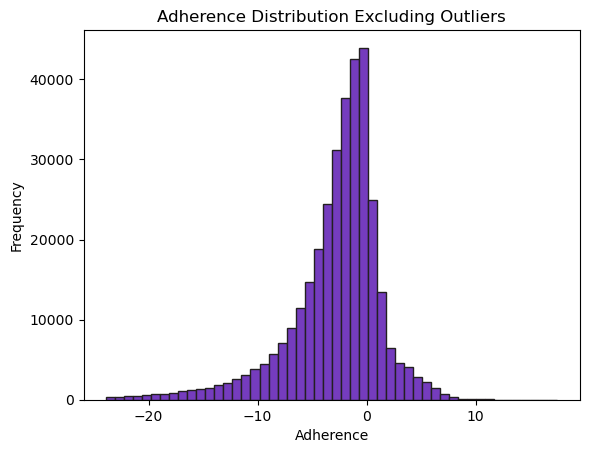

In [225]:
ax = (wego[wego['ADHERENCE'].between(adherence_mean - adherence_std*3,
                                   adherence_mean + adherence_std*3,
                                   inclusive='both')] ['ADHERENCE']
      .plot(kind='hist',  bins=50, color=purple, edgecolor=black))

ax.set(title='Adherence Distribution Excluding Outliers',
       xlabel='Adherence')

plt.show()

In [226]:
hdwy_mean = wego['HDWY_DEV'].mean()
hdwy_std = wego['HDWY_DEV'].std()

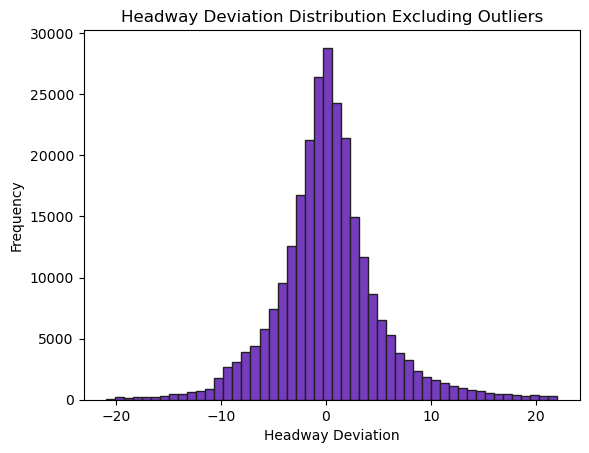

In [227]:
hdwy_mean = wego['HDWY_DEV'].mean()
hdwy_std = wego['HDWY_DEV'].std()
ax= (wego[wego['HDWY_DEV'].between(hdwy_mean - hdwy_std*3, 
                                  hdwy_mean + hdwy_std*3, 
                                  inclusive='both')]['HDWY_DEV']
     .plot(kind='hist', bins=50, color=purple, edgecolor=black))

ax.set(title='Headway Deviation Distribution Excluding Outliers',
    xlabel='Headway Deviation')

plt.show()

# Q2 
How does direction of travel, route, or location affect the headway and on-time performance?

In [228]:
#create HDWY_DEV PERCENTAGE COLUMN 
wego['HDWY_DEV_PCT'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']*100

#creat a function to show bunching, gapping and acceptable

In [229]:
# # Create Bunching or Gapping Indicator
# def is_hdwy_bunching(dev, pct):
#     if (dev < 0) & (pct > 50):
#         return int(1)
#     else:
#         return int(0)
# def is_hdwy_gapping(dev, pct):
#     if (dev > 0) & (pct > 50):
#         return int(1)
#     else:
#         return int(0)
# def is_hdwy_acceptable(pct):
#     if pct <= 50:
#         return int(1)
#     else:
#         return int(0)

In [230]:
def gapping(percentage):
    if (percentage < 0) & (abs(percentage) > 50):
        return int(1)
    else:
        return int(0)
    
def acceptable(percentage):
    if abs(percentage) <= 50:
        return int(1)
    else:
        return int(0)
    
def bunching(percentage):
    if (percentage > 0) & (abs(percentage) > 50):
        return int(1)
    else:
        return int(0)

In [231]:
# print(wego.HDWY_GAPPING.sum())
# print(wego.HDWY_ACCEPTABLE.sum())
# print(wego.HDWY_BUNCHING.sum())

#creat columns from the above function

In [232]:
wego['HDWY_BUNCHING']= wego['HDWY_DEV_PCT'].apply(bunching)
wego['HDWY_GAPPING']= wego['HDWY_DEV_PCT'].apply(gapping)
wego['HDWY_ACCEPTABLE']= wego['HDWY_DEV_PCT'].apply(acceptable)

In [233]:
wego.head(50)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,SCHEDULED_LAYOVER_MINUTES,DATE_TRIP,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,HOUR,DAY_OF_WEEK,WEEKDAY,WEEK_DAY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,$5.00,120230801-345105,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
5,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,120230801-345105,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
6,120230801,1,99457896,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,120230801-345105,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,$10.00,120230801-345106,$7.62,0,0,1,$5.00,Tuesday,1,Tuesday
8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,NaN,120230801-345106,$5.62,0,0,1,$5.00,Tuesday,1,Tuesday
9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,NaN,120230801-345106,$-3.22,0,0,1,$5.00,Tuesday,1,Tuesday


In [234]:
wego[wego['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']['ADHERENCE'].apply(['min','max','mean','median'])

min      $-948.53
max        $76.77
mean       $-3.96
median     $-2.52
Name: ADHERENCE, dtype: float64

In [235]:
wego[wego['ROUTE_DIRECTION_NAME']=='TO DOWNTOWN']['ADHERENCE'].apply(['min','max','mean','median'])

min      $-618.17
max        $88.38
mean       $-2.32
median     $-1.50
Name: ADHERENCE, dtype: float64

In [236]:
wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_DEV','ADHERENCE']].describe()

HDWY_DEV                                         \
                           count  mean   std     min    25%   50%   75%   
ROUTE_DIRECTION_NAME                                                      
FROM DOWNTOWN        $141,392.00 $0.58 $7.77 $-55.53 $-2.65 $0.03 $2.85   
TO DOWNTOWN          $124,501.00 $0.45 $6.40 $-64.00 $-2.00 $0.03 $2.15   

                               ADHERENCE                                      \
                         max       count   mean   std      min    25%    50%   
ROUTE_DIRECTION_NAME                                                           
FROM DOWNTOWN        $565.43 $179,306.00 $-3.96 $7.23 $-948.53 $-5.47 $-2.52   
TO DOWNTOWN          $543.83 $159,555.00 $-2.32 $6.39 $-618.17 $-3.67 $-1.50   

                                    
                        75%    max  
ROUTE_DIRECTION_NAME                
FROM DOWNTOWN        $-0.63 $76.77  
TO DOWNTOWN          $-0.10 $88.38

#to downtown seems a better performance 

In [237]:
# #make sure to create columns if you use htis function
# # Calculate HDWY Deviation Percentage
# def get_dev_pct(row):
#     '''Takes a row as input, returns a perfencate value. 
# #     Calculate the headway deviation percentage taking into
# #     consideration the possibility of SCHEDULED_HDWY being 0'''
#     if row['SCHEDULED_HDWY'] != 0:
#         return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
#     else:
#         return np.NaN

# # create headway deviation percentable column
# wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

C:\Users\zenas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


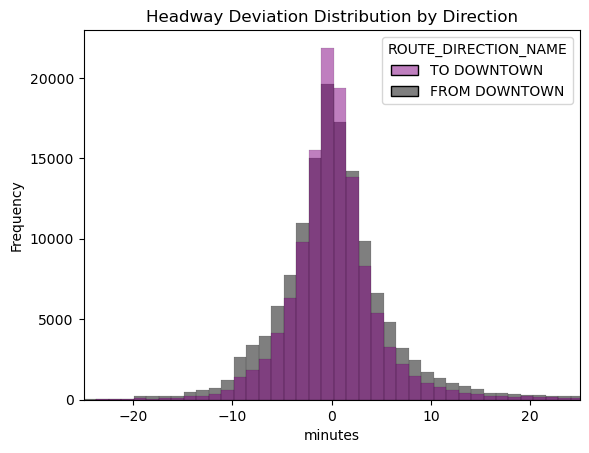

In [238]:
colors = {
    'TO DOWNTOWN': 'purple',
    'FROM DOWNTOWN': 'black',
}

sns.histplot(data=wego, x='HDWY_DEV', hue='ROUTE_DIRECTION_NAME', bins=500, palette=colors)
plt.title('Headway Deviation Distribution by Direction')
plt.xlabel('minutes')
plt.ylabel('Frequency')
plt.xlim(-25,25)
#plt.ylim(0,65000)
plt.show()

C:\Users\zenas\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


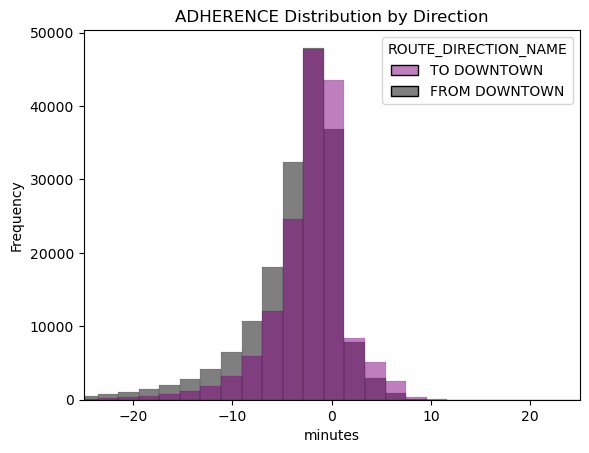

In [239]:
sns.histplot(data=wego, x='ADHERENCE', hue='ROUTE_DIRECTION_NAME', bins=500, palette=colors) 
plt.title('ADHERENCE Distribution by Direction')
plt.xlabel('minutes')
plt.ylabel('Frequency')
plt.xlim(-25,25)
#plt.ylim(0,65000)
plt.show()

In [240]:
wego['HDWY_DEV'].min()

-64.0

In [241]:
wego['HDWY_DEV'].max()

565.433333

In [242]:
wego.groupby('ROUTE_ABBR')[['HDWY_DEV','ADHERENCE']].describe()

HDWY_DEV                                                   \
                count  mean    std     min    25%    50%   75%     max   
ROUTE_ABBR                                                               
3          $36,583.00 $0.58  $6.20 $-64.00 $-2.45  $0.12 $2.80  $76.87   
7          $11,578.00 $0.34  $5.91 $-30.43 $-1.98  $0.03 $2.13  $50.25   
22         $17,007.00 $0.96 $10.25 $-43.65 $-1.97  $0.05 $2.20 $508.70   
23         $28,478.00 $1.05  $9.88 $-32.12 $-1.73  $0.07 $2.07 $565.43   
50         $34,593.00 $0.21  $4.76 $-33.25 $-2.08  $0.03 $2.18  $54.28   
52         $39,887.00 $0.97  $9.19 $-55.53 $-2.45  $0.08 $2.78 $472.37   
55         $49,432.00 $0.26  $6.36 $-29.93 $-3.15 $-0.03 $2.98 $102.00   
56         $48,335.00 $0.15  $4.71 $-27.27 $-2.33  $0.00 $2.38 $166.00   

            ADHERENCE                                                    
                count   mean   std      min    25%    50%    75%    max  
ROUTE_ABBR                                                               
3          $45,488.00 $-3.76 $5.42 $-133.25 $-5.35 $-2.57 $-0.77 $33.75  
7          $17,267.00 $-3.35 $6.67  $-87.72 $-4.92 $-2.12 $-0.62 $88.38  
22         $25,188.00 $-1.14 $6.39 $-675.00 $-2.95 $-0.93  $0.82 $24.73  
23         $39,653.00 $-1.76 $7.68 $-618.17 $-3.12 $-1.32  $0.03 $33.63  
50         $42,629.00 $-2.51 $6.16 $-489.32 $-3.88 $-1.80 $-0.30 $22.35  
52         $49,327.00 $-3.97 $8.72 $-948.53 $-5.02 $-2.07 $-0.40 $30.20  
55         $60,359.00 $-4.82 $7.54 $-375.23 $-6.58 $-2.88 $-0.85 $40.25  
56         $58,950.00 $-2.70 $4.93 $-322.78 $-4.30 $-1.90 $-0.28 $39.92

#Redo Q2
#Adherence by Direction

In [243]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_GAPPING', 'HDWY_ACCEPTABLE', 'HOUR',
       'DAY_OF_WEEK', 'WEEKDAY', 'WEEK_DAY'],
      dtype='object')

In [244]:
wego[wego['ROUTE_DIRECTION_NAME']=='TO DOWNTOWN']['HDWY_DEV_PCT'].mean()

inf

In [245]:
wego[wego['ROUTE_DIRECTION_NAME']=='FROM DOWNTOWN']['HDWY_DEV_PCT'].mean()

3.68861436967126

#Adherence by direction

In [246]:
direction_adher = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum()

In [247]:
direction_adher

,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_DIRECTION_NAME,,,
FROM DOWNTOWN,5291,39601,134414
TO DOWNTOWN,4484,19437,135634


In [248]:
routes_adher = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()


In [249]:
routes_adher

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
ROUTE_DIRECTION_NAME,,,
FROM DOWNTOWN,134414,39601,5291
TO DOWNTOWN,135634,19437,4484


In [250]:

direction_adher['TOTALS'] = direction_adher.sum(axis=1)

In [251]:
direction_adher['ONTIME_PCT'] =direction_adher['ADJUSTED_ONTIME_COUNT'] / direction_adher['TOTALS'] * 100
direction_adher['EARLY_PCT'] =direction_adher['ADJUSTED_EARLY_COUNT'] / direction_adher['TOTALS'] * 100
direction_adher['LATE_PCT'] = direction_adher['ADJUSTED_LATE_COUNT'] / direction_adher['TOTALS'] * 100

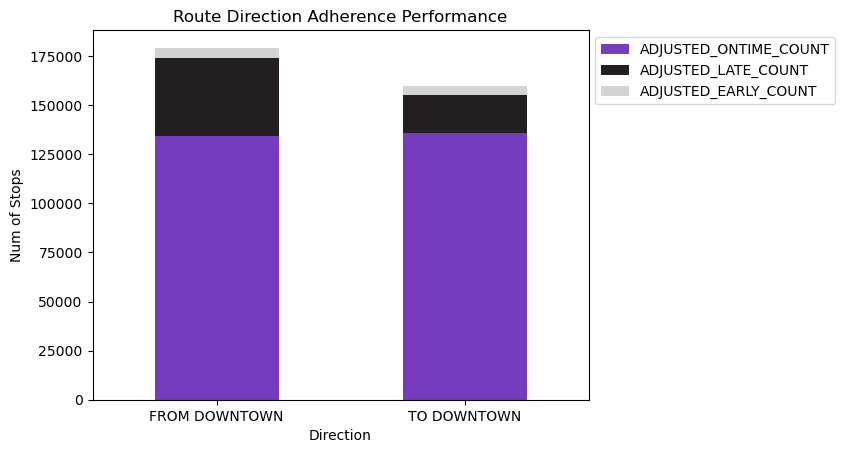

In [252]:
ax = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Route Direction Adherence Performance',
        xlabel = 'Direction',
        ylabel = 'Num of Stops')
ax.tick_params(axis='x', rotation=0)
ax.legend(bbox_to_anchor=(1, 1))

plt.show()


#dherence by Route

In [253]:
route_adher = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()
         

In [254]:
route_adher

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
ROUTE_ABBR,,,
3,34516,9590,1382
7,13417,3417,433
22,22492,2065,631
23,35137,3230,1286
50,36309,5113,1207
52,37736,10038,1553
55,42080,16748,1531
56,48361,8837,1752


In [255]:
route_adher['TOTALS'] = route_adher.sum(axis=1)

In [256]:
route_adher['ONTIME_PCT'] =route_adher['ADJUSTED_ONTIME_COUNT'] / route_adher['TOTALS'] * 100
route_adher['EARLY_PCT'] = route_adher['ADJUSTED_EARLY_COUNT'] / route_adher['TOTALS'] * 100
route_adher['LATE_PCT'] = route_adher['ADJUSTED_LATE_COUNT'] / route_adher['TOTALS'] * 100

In [257]:
#with out creating a total column and percentage 

# ax = (wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()
    
# ).plot(kind='bar', stacked=True)
# ax.set(title = 'Route Adherence Performance',
#         xlabel = 'Route',
#         ylabel = 'Num of Stops')
# ax.tick_params(axis='x', rotation=0)
# ax.legend(bbox_to_anchor=(1, 1))

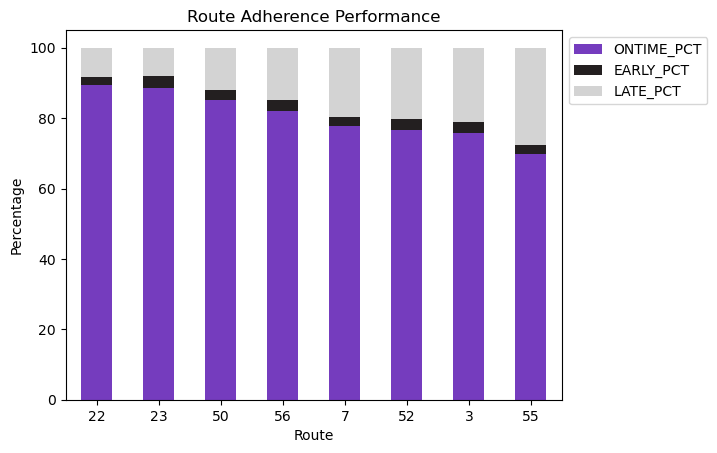

In [258]:
ax = (
   route_adher[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

plt.show()

#
Headway by Direction

In [259]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_GAPPING', 'HDWY_ACCEPTABLE', 'HOUR',
       'DAY_OF_WEEK', 'WEEKDAY', 'WEEK_DAY'],
      dtype='object')

In [260]:
wego['HDWY_ACCEPTABLE'].value_counts()

HDWY_ACCEPTABLE
1    225918
0    112943
Name: count, dtype: int64

In [261]:
wego['HDWY_BUNCHING'].value_counts()

HDWY_BUNCHING
0    316888
1     21973
Name: count, dtype: int64

In [262]:
wego['HDWY_GAPPING'].value_counts()

HDWY_GAPPING
0    320862
1     17999
Name: count, dtype: int64

In [263]:
routes_totals = wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_BUNCHING','HDWY_GAPPING','HDWY_ACCEPTABLE']].sum()


In [264]:
routes_totals['TOTALS'] = routes_totals.sum(axis=1)

In [265]:
routes_totals['BUNCHING_PCT'] = (routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS']) * 100
routes_totals['GAPPING_PCT'] = (routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS']) * 100
routes_totals['ACCEPTABLE_PCT'] = (routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS']) * 100

In [266]:
routes_totals

,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,TOTALS,BUNCHING_PCT,GAPPING_PCT,ACCEPTABLE_PCT
ROUTE_DIRECTION_NAME,,,,,,,
FROM DOWNTOWN,13715,11755,115922,141392,$9.70,$8.31,$81.99
TO DOWNTOWN,8258,6244,109996,124498,$6.63,$5.02,$88.35


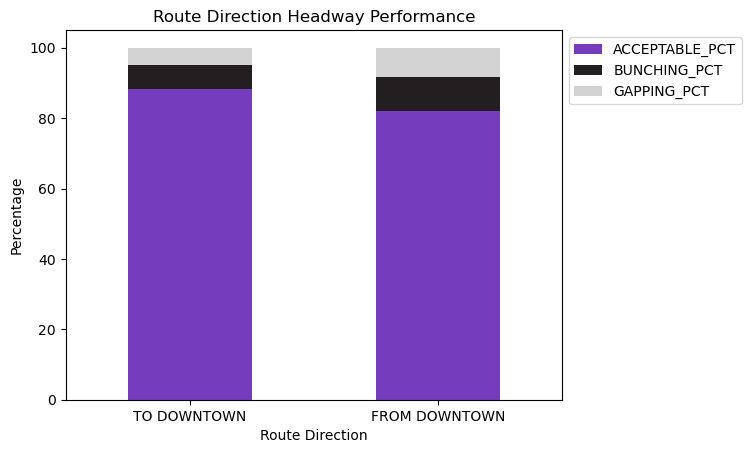

In [267]:
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Route Direction Headway Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

plt.show()


#Headway By Route

In [268]:
routes_number_totals = wego.groupby('ROUTE_ABBR')[['HDWY_BUNCHING','HDWY_GAPPING','HDWY_ACCEPTABLE']].sum()


In [269]:
routes_number_totals

,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE
ROUTE_ABBR,,,
3,2944,2179,31460
7,615,463,10500
22,739,297,15971
23,1946,730,25802
50,1408,1056,32129
52,3828,3009,33050
55,6484,6569,36379
56,4009,3696,40627


In [270]:
routes_number_totals['TOTALS'] = routes_number_totals.sum(axis=1)

In [271]:
routes_number_totals['BUNCHING_PCT'] = (routes_number_totals['HDWY_BUNCHING'] / routes_number_totals['TOTALS']) * 100
routes_number_totals['GAPPING_PCT'] = (routes_number_totals['HDWY_GAPPING'] / routes_number_totals['TOTALS']) * 100
routes_number_totals['ACCEPTABLE_PCT'] = (routes_number_totals['HDWY_ACCEPTABLE'] / routes_number_totals['TOTALS']) * 100

In [272]:
routes_number_totals

,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,TOTALS,BUNCHING_PCT,GAPPING_PCT,ACCEPTABLE_PCT
ROUTE_ABBR,,,,,,,
3,2944,2179,31460,36583,$8.05,$5.96,$86.00
7,615,463,10500,11578,$5.31,$4.00,$90.69
22,739,297,15971,17007,$4.35,$1.75,$93.91
23,1946,730,25802,28478,$6.83,$2.56,$90.60
50,1408,1056,32129,34593,$4.07,$3.05,$92.88
52,3828,3009,33050,39887,$9.60,$7.54,$82.86
55,6484,6569,36379,49432,$13.12,$13.29,$73.59
56,4009,3696,40627,48332,$8.29,$7.65,$84.06


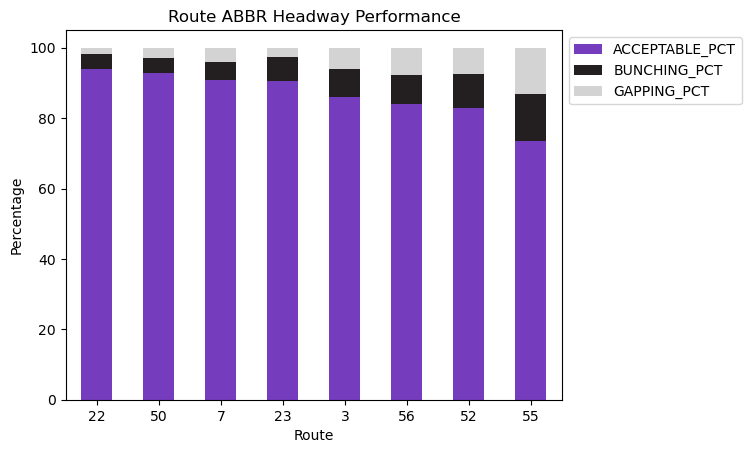

In [273]:
ax = (
    routes_number_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Route ABBR Headway Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

plt.show()

In [274]:
#count 
wego[['HDWY_BUNCHING','HDWY_GAPPING','HDWY_ACCEPTABLE']].sum()

HDWY_BUNCHING       21973
HDWY_GAPPING        17999
HDWY_ACCEPTABLE    225918
dtype: int64

#Adherence by location 

In [275]:
# TIME_POINT_ABBR column shows STOPS OR LOCATION
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,$-37.57,NaN
MCC4_20,$-13.36,NaN
MCC5_12,$-9.79,NaN
MCC5_7,$-9.08,NaN
DCSCC,$-7.09,$12.05
...,...,...
HEAD,$1.01,NaN
MCC5_2,$1.25,NaN
25ACLARK,$1.46,$0.55


In [276]:
# Create new df for Adherence columns grouped by Location
location_totals=wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()


In [277]:
# Create new total column for each row
location_totals['TOTALS'] = location_totals.sum(axis=1)

In [278]:
# Create new percentage column for each category
location_totals['ONTIME_PCT'] = location_totals['ADJUSTED_ONTIME_COUNT'] / location_totals['TOTALS'] * 100
location_totals['EARLY_PCT'] = location_totals['ADJUSTED_EARLY_COUNT'] / location_totals['TOTALS'] * 100
location_totals['LATE_PCT'] = location_totals['ADJUSTED_LATE_COUNT'] / location_totals['TOTALS'] * 100

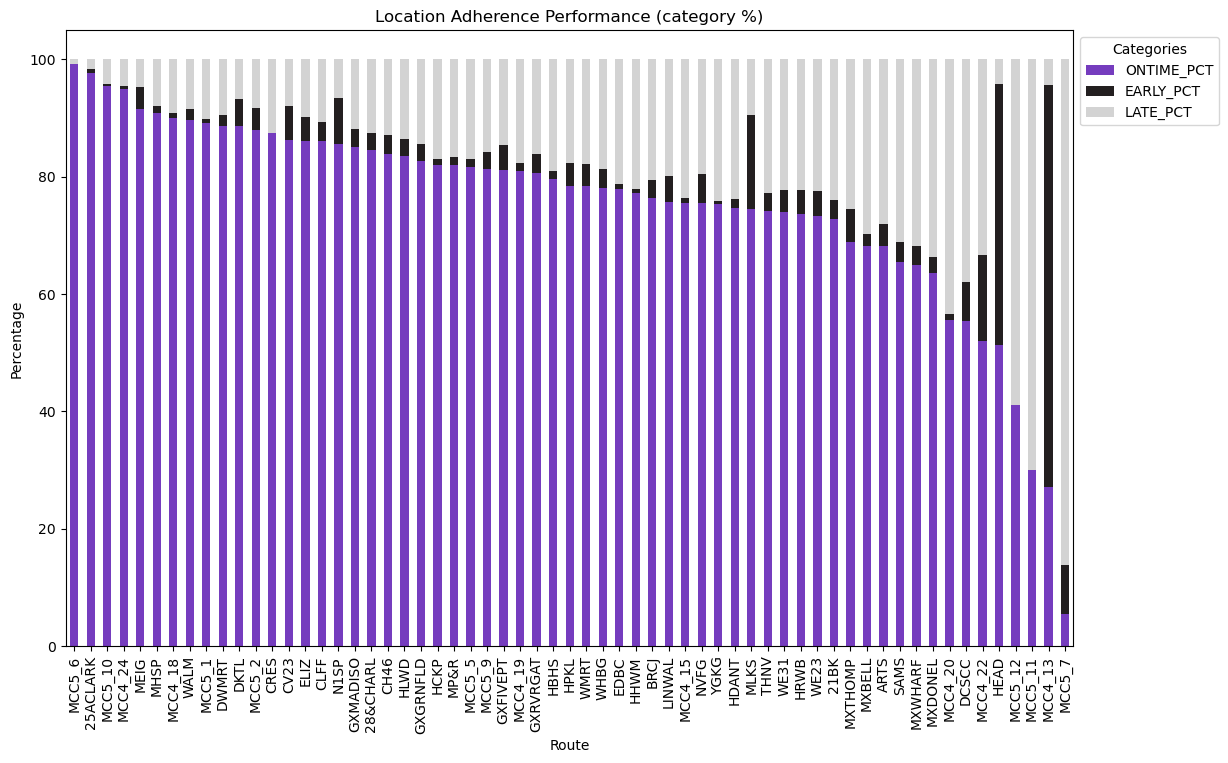

In [279]:
# Location Adherence graph
ax = (location_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13, 8), color=[purple,black,gray])
ax.set(title = 'Location Adherence Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

plt.show()

#Headwya by location 

In [280]:
# Create new df for Headway columns grouped by Location
hdwy_location_totals = wego.groupby('TIME_POINT_ABBR')[['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum()

In [281]:
hdwy_location_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
TIME_POINT_ABBR,,,
21BK,367,5119,287
25ACLARK,28,1100,4
28&CHARL,285,6407,222
ARTS,16,0,0
BRCJ,238,3553,96
...,...,...,...
WE23,787,6755,627
WE31,798,6745,632
WHBG,389,8355,278


In [282]:
# Create new total column for each row
hdwy_location_totals['TOTALS'] = hdwy_location_totals.sum(axis=1)

In [283]:
# Create new percentage column for each category
# the .loc[:, avoids common mistakes or problems
hdwy_location_totals.loc[:, 'BUNCHING_PCT'] = hdwy_location_totals['HDWY_BUNCHING'] / hdwy_location_totals['TOTALS'] * 100
hdwy_location_totals.loc[:, 'ACCEPTABLE_PCT'] = hdwy_location_totals['HDWY_ACCEPTABLE'] / hdwy_location_totals['TOTALS'] * 100
hdwy_location_totals.loc[:, 'GAPPING_PCT'] = hdwy_location_totals['HDWY_GAPPING'] / hdwy_location_totals['TOTALS'] * 100

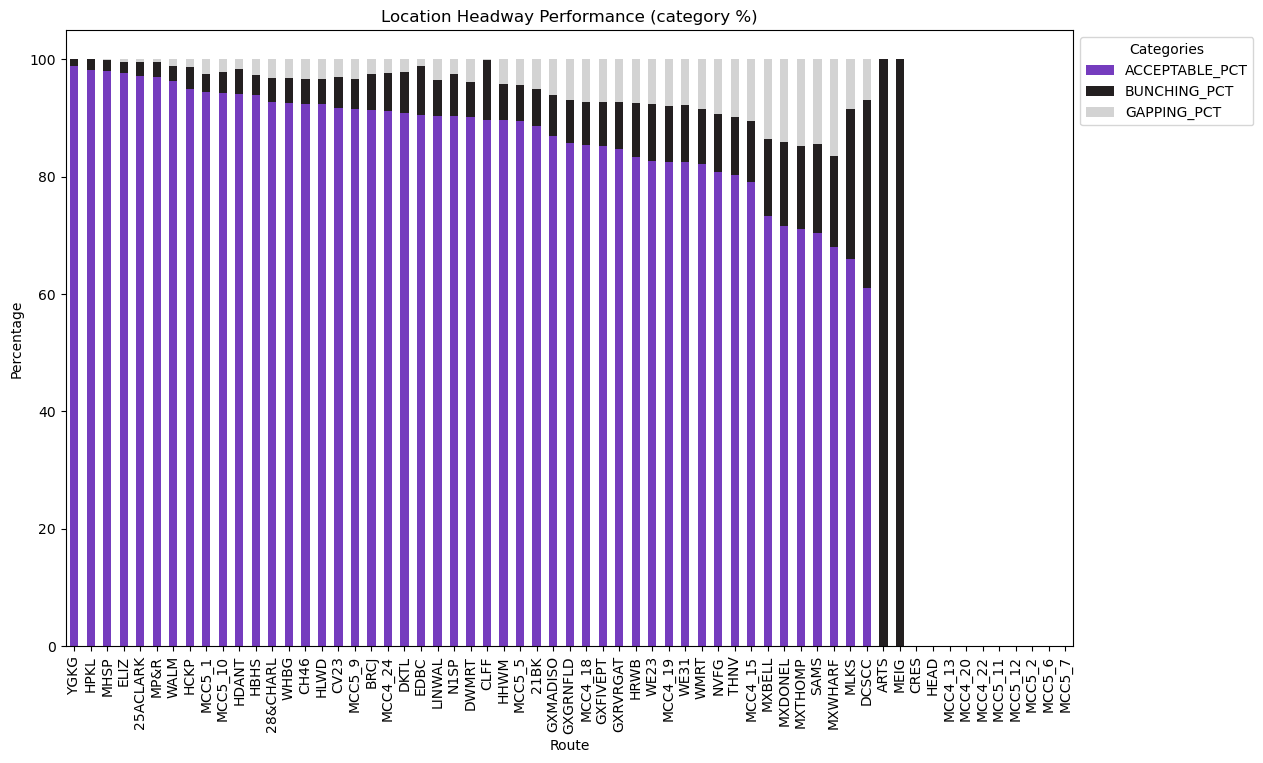

In [284]:
# Location Adherence graph
ax = (hdwy_location_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
            ).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True, figsize=(13, 8), color=[purple,black,gray])
    
ax.set(title = 'Location Headway Performance (category %)',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
# ax.tick_params(axis='x', rotation=0)

plt.show()


# Q3
# How does time of day or day of week affect headway and on-time performance?

In [285]:
#create HDWY_DEV PERCENTAGE COLUMN 
wego['HDWY_DEV_PCT'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']*100

In [286]:
#create hour and day of week column
wego['ACTUAL_ARRIVAL_TIME'] = pd.to_datetime(wego['ACTUAL_ARRIVAL_TIME'])
wego['HOUR'] = wego['ACTUAL_ARRIVAL_TIME'].dt.hour
wego['DAY_OF_WEEK'] = wego['ACTUAL_ARRIVAL_TIME'].dt.day_name()

In [287]:
# create weekday column
wego['WEEKDAY'] = pd.to_datetime(wego['DATE']).dt.weekday

In [288]:
 #creat time column
# clean_departure_time['DEPART_TIME'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME'],format = 'mixed')
#  wego['DEPART_TIME'] = wego['DEPART_TIME'].dt.strftime('%H:%M:%S')

In [289]:
 #wego.dtypes

In [290]:
 wego['DATE']=pd.to_datetime(wego['DATE'])

In [291]:
# wego.dtypes

In [292]:
clean_departure_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [293]:
clean_departure_time

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,SCHEDULED_LAYOVER_MINUTES,DATE_TRIP,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,HOUR,DAY_OF_WEEK,WEEKDAY,WEEK_DAY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,$5.00,120230801-345105,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,120230930-353448,$17.56,0,0,1,$22.00,Saturday,5,Saturday
350325,120230930,2,100406611,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,NaN,120230930-353448,NaN,0,0,0,$22.00,Saturday,5,Saturday
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,NaN,120230930-353449,$6.22,0,0,1,$22.00,Saturday,5,Saturday
350327,120230930,2,100406613,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,NaN,120230930-353449,$58.33,1,0,0,$23.00,Saturday,5,Saturday


In [294]:
#clean_departure_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()

#Adherence by hour

In [295]:
# Create new df for Adherence columns grouped by Hour
total_hours =clean_departure_time.groupby('HOUR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()


In [296]:
# Create new total column for each row
total_hours['TOTALS'] = total_hours.sum(axis=1)

In [297]:
total_hours['TOTALS']

HOUR
$0.00      4237
$1.00       191
$3.00       130
$4.00      2074
$5.00     10455
$6.00     18925
$7.00     21292
$8.00     21011
$9.00     20362
$10.00    20332
$11.00    19684
$12.00    20015
$13.00    20151
$14.00    20442
$15.00    21281
$16.00    21682
$17.00    21017
$18.00    17564
$19.00    13550
$20.00    12454
$21.00    11860
$22.00    11097
$23.00     9052
Name: TOTALS, dtype: int64

In [298]:
# Create new percentage column for each category
total_hours.loc[:, 'ONTIME_PCT'] = total_hours['ADJUSTED_ONTIME_COUNT'] / total_hours['TOTALS'] * 100
total_hours.loc[:, 'EARLY_PCT'] = total_hours['ADJUSTED_EARLY_COUNT'] / total_hours['TOTALS'] * 100
total_hours.loc[:, 'LATE_PCT'] = total_hours['ADJUSTED_LATE_COUNT'] / total_hours['TOTALS'] * 100

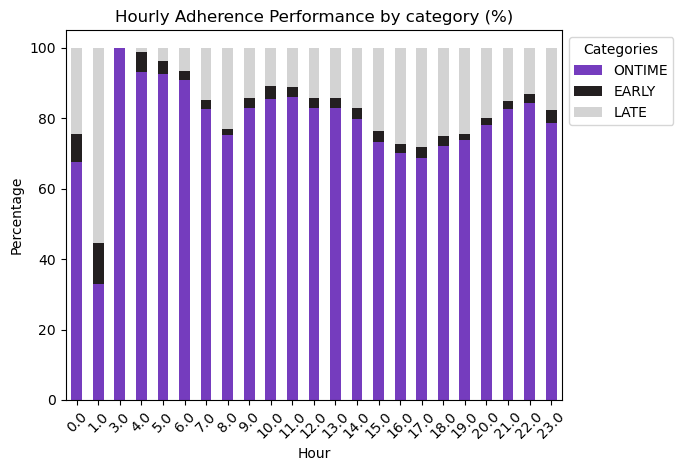

In [331]:
# Hour Adherence graph
ax = (total_hours[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Hourly Adherence Performance by category (%)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories', labels =  ['ONTIME', 'EARLY', 'LATE'])
                                                                       
ax.tick_params(axis='x', rotation=45)

plt.show()

#Headway by hour

In [300]:
hdwy_hours = clean_departure_time.groupby('HOUR')[['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum()


In [301]:
hdwy_hours

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
HOUR,,,
$0.00,184,2545,191
$1.00,20,44,10
$3.00,0,0,0
$4.00,3,602,8
$5.00,177,6082,104
$6.00,811,13695,566
$7.00,1482,14228,1005
$8.00,1640,13547,1569
$9.00,1201,13958,1168


In [302]:
# Create new total column for each row
hdwy_hours['TOTALS'] = hdwy_hours.sum(axis=1)

In [303]:
# Create new percentage column for each category
hdwy_hours.loc[:, 'BUNCHING_PCT'] = hdwy_hours['HDWY_BUNCHING'] / hdwy_hours['TOTALS'] * 100
hdwy_hours.loc[:, 'ACCEPTABLE_PCT'] =hdwy_hours['HDWY_ACCEPTABLE'] / hdwy_hours['TOTALS'] * 100
hdwy_hours.loc[:, 'GAPPING_PCT'] = hdwy_hours['HDWY_GAPPING'] / hdwy_hours['TOTALS'] * 100

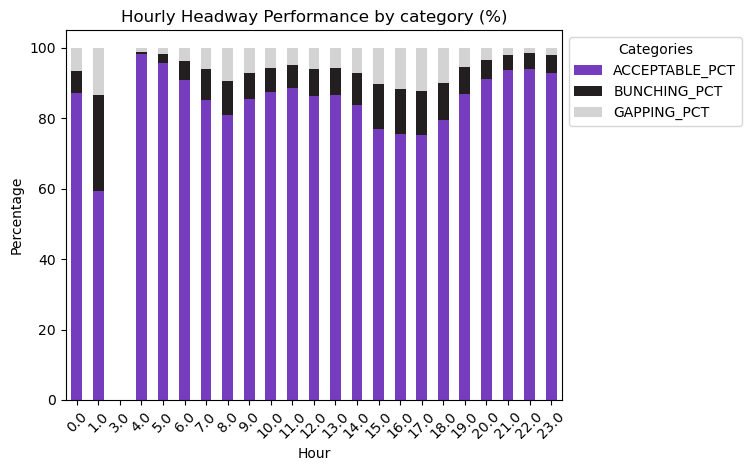

In [326]:
# Hour Headway graph
ax = (hdwy_hours[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).plot(kind='bar', stacked=True, color=[purple,black,gray])
ax.set(title = 'Hourly Headway Performance by category (%)',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.tick_params(axis='x', rotation=45)

plt.show()

#Adherence by weekday

In [305]:
# # # Convert depart time column to datetime
# clean_departure_time['DEPART_TIME'] = ([pd.to_datetime('2000-01-01 ' + str(t), format='mixed')
#                                    for t in clean_departure_time['TIME']])

In [306]:
# # Create Weekday column
# clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['DATE']).dt.weekday

In [307]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_GAPPING', 'HDWY_ACCEPTABLE', 'HOUR',
       'DAY_OF_WEEK', 'WEEKDAY', 'WEEK_DAY'],
      dtype='object')

In [308]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,SCHEDULED_LAYOVER_MINUTES,DATE_TRIP,HDWY_DEV_PCT,HDWY_BUNCHING,HDWY_GAPPING,HDWY_ACCEPTABLE,HOUR,DAY_OF_WEEK,WEEKDAY,WEEK_DAY
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$4.00,Tuesday,1,Tuesday
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,120230801-345104,NaN,0,0,0,$5.00,Tuesday,1,Tuesday
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,$5.00,120230801-345105,NaN,0,0,0,$5.00,Tuesday,1,Tuesday


In [309]:
# use Grouper to group by Weekday
wego_by_day =   clean_departure_time.groupby(pd.Grouper(key='WEEKDAY'))

In [310]:
wego_by_day

In [311]:
# Create new df for Adherence columns grouped by Weekday
weekday_totals = wego_by_day [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()

In [312]:
# Create new total column for each row
weekday_totals['TOTALS'] = weekday_totals.sum(axis=1)

In [313]:
weekday_totals['TOTALS']

WEEKDAY
1    56774
2    56941
3    56267
4    55914
5    36530
6    28446
0    47989
Name: TOTALS, dtype: int64

In [314]:
# Create new percentage column for each category
# weekday_totals.loc[:, 'ONTIME_PCT'] = weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS'] * 100
# weekday_totals.loc[:, 'EARLY_PCT'] = weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS'] * 100
# weekday_totals.loc[:, 'LATE_PCT'] = weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS'] * 100

In [315]:
weekday_totals['ONTIME_PCT'] = (weekday_totals['ADJUSTED_ONTIME_COUNT'] / weekday_totals['TOTALS']) * 100
weekday_totals['EARLY_PCT'] = (weekday_totals['ADJUSTED_EARLY_COUNT'] / weekday_totals['TOTALS']) * 100
weekday_totals['LATE_PCT'] = (weekday_totals['ADJUSTED_LATE_COUNT'] / weekday_totals['TOTALS']) * 100

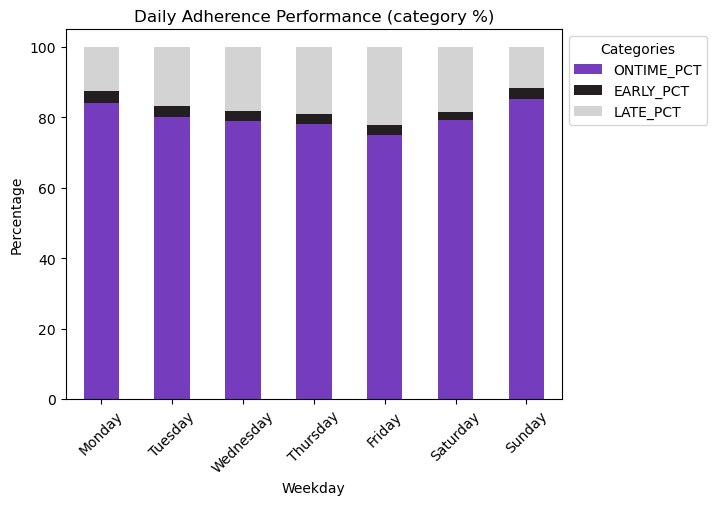

In [316]:
# Hour Adherence graph
ax = (weekday_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
                ).sort_index().plot(kind='bar', stacked=True, color=[purple,black,gray])

ax.set(title = 'Daily Adherence Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
#ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

plt.show()


#Headway by weekday

In [317]:
# Create new df for Headway columns grouped by Weekday
hdwy_weekday_totals = (
    wego_by_day
         [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']]
         .sum())

In [318]:
hdwy_weekday_totals['TOTALS'] = hdwy_weekday_totals.sum(axis=1)

In [319]:
# Create new percentage column for each category
hdwy_weekday_totals['BUNCHING_PCT'] = hdwy_weekday_totals['HDWY_BUNCHING'] / hdwy_weekday_totals['TOTALS'] * 100
hdwy_weekday_totals['ACCEPTABLE_PCT'] = hdwy_weekday_totals['HDWY_ACCEPTABLE'] /hdwy_weekday_totals['TOTALS'] * 100
hdwy_weekday_totals['GAPPING_PCT'] = hdwy_weekday_totals['HDWY_GAPPING'] / hdwy_weekday_totals['TOTALS'] * 100

In [320]:
hdwy_weekday_totals

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,TOTALS,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
WEEKDAY,,,,,,,
1,3825,37530,3239,44594,$8.58,$84.16,$7.26
2,3955,37301,3444,44700,$8.85,$83.45,$7.70
3,4290,36404,3525,44219,$9.70,$82.33,$7.97
4,4911,35014,4028,43953,$11.17,$79.66,$9.16
5,1397,26108,1039,28544,$4.89,$91.47,$3.64
6,1015,20686,483,22184,$4.58,$93.25,$2.18
0,2580,32875,2241,37696,$6.84,$87.21,$5.94


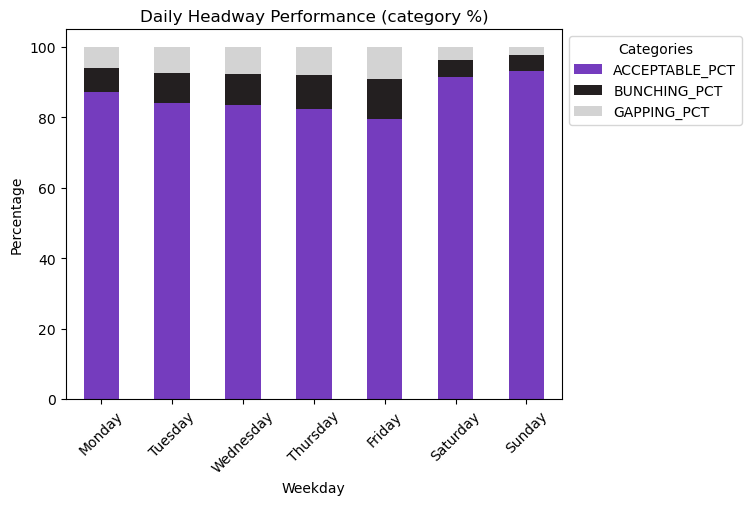

In [321]:
# Hour Adherence graph
ax = (hdwy_weekday_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
                ).sort_index().plot(kind='bar', stacked=True, color=[purple,black,gray])

ax.set(title = 'Daily Headway Performance (category %)',
        xlabel = 'Weekday',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1), title='Categories')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

plt.show()

#NO TRIPS WERE MADE DURING THE HOURS OF 2 AND 3

In [322]:
wego['HDWY_DEV']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
350324    $5.27
350325      NaN
350326    $1.87
350327   $17.50
350328      NaN
Name: HDWY_DEV, Length: 338861, dtype: float64

## Q3
How does time of day or day of week affect headway and on-time performance?

In [131]:
#wego.head()

In [132]:
wego['WEEK_DAY'] = wego['DATE'].dt.day_name()

In [133]:
#wego.head()

In [134]:
wego['TIME_POINT_ABBR'].nunique()

61

In [135]:
#headway deviation by hour
#HOURLY_HDWY_DEVIATION = wego.groupby('HOUR')['HDWY_DEV_PCT'].describe()


In [136]:
#HOURLY_HDWY_DEVIATION

In [137]:
# wego['HDWY_DEV_PCT'].dropna()

In [138]:
#headway deviation by day of week
# DAILY_HDWY_DEVIATION = wego.groupby('DAY_OF_WEEK')['HDWY_DEV_PCT'].describe().reset_index()

In [139]:
# DAILY_HDWY_DEVIATION

In [140]:
# DAILY_HDWY_DEVIATION.boxplot(column = 'HDWY_DEV_PCT', by = 'HOUR')
# plt.xlabel('HOUR')
# plt.ylabel('HDWY_DEV_PCT')
# plt.xticks(rotation = 90)
# plt.title('Headway Deviation Percentage by Hour')

# plt.show()

# HOURLY_HDWY_DEVIATION['count'].plot(kind='line', title='Headway Deviation by Time of Day')
# plt.show()

In [141]:
#  headway deviation by day of week
#daily_hdwy_deviation = wego.groupby('DAY_OF_WEEK')['HDWY_DEV_PCT'].describe().reset_index()

# DAILY_HDWY_DEVIATION.boxplot(column = 'mean', by='DAY_OF_WEEK')
# plt.title('Mean Headway Deviation Percentage by Day of Week')
# plt.xlabel('DAY_OF_WEEK')
# plt.ylabel('Mean Headway Deviation Percentage')
# plt.xticks(rotation=45)
# plt.show()

# DAILY_HDWY_DEVIATION['count'].plot(kind='bar', title='Headway Deviation by Day of Week', x='DAY_OF_WEEK')

# plt.show()

In [142]:
# # Hourly Adherence
# wego.groupby('HOUR')[['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum()


In [143]:
# Dalily Adherence 
#Daily_adherence = wego.groupby('DAY_OF_WEEK')[['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum().reset_index()

In [144]:
#Daily_adherence

# Q4
How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

#create a new dataframe for Adherance

In [145]:
wego.groupby('OPERATOR')[['HDWY_DEV','ADHERENCE']].mean()


,HDWY_DEV,ADHERENCE
OPERATOR,,
0,NaN,8.916666
56,-0.250000,-1.138889
235,1.918518,-3.947222
244,-0.037500,-3.466666
301,2.832222,-4.971171
...,...,...
3149,1.434226,-0.993939
3156,0.759347,-4.489942
3165,5.553472,-7.501562


Adherence by operator

In [146]:
# Create new df for Adherence columns grouped by OPERATOR
operator_adherence_total = wego.groupby('OPERATOR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum()


In [147]:
#create a new adherence total column
operator_adherence_total['ADHER_TOTAL'] = operator_adherence_total[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum(axis=1)

In [148]:
# Create new percentage column for each category
operator_adherence_total['ONTIME_PCT'] = operator_adherence_total['ADJUSTED_ONTIME_COUNT'] / operator_adherence_total['ADHER_TOTAL'] * 100
operator_adherence_total['EARLY_PCT'] = operator_adherence_total['ADJUSTED_EARLY_COUNT'] / operator_adherence_total['ADHER_TOTAL'] * 100
operator_adherence_total['LATE_PCT'] =operator_adherence_total['ADJUSTED_LATE_COUNT'] / operator_adherence_total['ADHER_TOTAL'] * 100

creat the top 20 operator

In [149]:
top_20_adhe = operator_adherence_total.loc[operator_adherence_total['ADHER_TOTAL']>=1000].nlargest(20,'ONTIME_PCT')

In [150]:
top_20_adhe

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADHER_TOTAL,ONTIME_PCT,EARLY_PCT,LATE_PCT
OPERATOR,,,,,,,
1762,2294,23,16,2333,98.328333,0.685812,0.985855
409,2310,61,9,2380,97.058824,0.378151,2.563025
1566,2135,48,17,2200,97.045455,0.772727,2.181818
522,1753,53,13,1819,96.371633,0.714678,2.913689
379,2172,56,31,2259,96.148738,1.372289,2.478973
1927,2317,58,38,2413,96.021550,1.574803,2.403647
723,1203,26,25,1254,95.933014,1.993620,2.073365
1040,1695,22,53,1770,95.762712,2.994350,1.242938
1133,2505,107,13,2625,95.428571,0.495238,4.076190


In [151]:
# Operator Adherence graph
#operator_adherence_total.boxplot(column=['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']) 

Headway by Operator

In [152]:
# create a new column for Hedway grouped by operator
hdwy_operator_total = wego.groupby('OPERATOR') [['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum()

In [153]:
hdwy_operator_total.head()

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING
OPERATOR,,,
0,0,0,0
56,0,2,0
235,2,7,0
244,4,13,3
301,10,16,4


In [154]:
#create a new hdwy total column
hdwy_operator_total['HDWY_TOTAL'] = hdwy_operator_total[['HDWY_BUNCHING', 'HDWY_ACCEPTABLE', 'HDWY_GAPPING']].sum(axis=1)

In [155]:
#create a new percentage column
hdwy_operator_total['BUNCHING_PCT'] =  hdwy_operator_total['HDWY_BUNCHING']/hdwy_operator_total['HDWY_TOTAL']*100
hdwy_operator_total['ACCEPTABLE_PCT'] =  hdwy_operator_total['HDWY_ACCEPTABLE']/hdwy_operator_total['HDWY_TOTAL']*100
hdwy_operator_total['GAPPING_PCT'] =  hdwy_operator_total['HDWY_GAPPING']/hdwy_operator_total['HDWY_TOTAL']*100

In [156]:
top_20_hdwy =hdwy_operator_total.loc[hdwy_operator_total['HDWY_TOTAL']>=1000].nlargest(20,'ACCEPTABLE_PCT')

In [157]:
top_20_hdwy

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,HDWY_TOTAL,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
OPERATOR,,,,,,,
1566,4,1799,32,1835,0.217984,98.038147,1.743869
1040,25,1030,3,1058,2.362949,97.353497,0.283554
1617,28,1245,8,1281,2.185792,97.189696,0.624512
409,33,1657,25,1715,1.924198,96.618076,1.457726
1992,42,1423,22,1487,2.824479,95.696032,1.479489
1927,55,1869,36,1960,2.806122,95.357143,1.836735
1368,66,1611,31,1708,3.864169,94.320843,1.814988
1410,71,1756,38,1865,3.806971,94.155496,2.037534
2088,54,1438,36,1528,3.534031,94.109948,2.356021


In [158]:
top_operators = pd.merge(top_20_adhe[['ADHER_TOTAL','ONTIME_PCT']],top_20_hdwy[['HDWY_TOTAL','ACCEPTABLE_PCT']],how = 'inner',left_index=True,right_index = True)

In [159]:
top_operators

,ADHER_TOTAL,ONTIME_PCT,HDWY_TOTAL,ACCEPTABLE_PCT
OPERATOR,,,,
1762,2333,98.328333,1553,91.435930
409,2380,97.058824,1715,96.618076
1566,2200,97.045455,1835,98.038147
1927,2413,96.021550,1960,95.357143
1040,1770,95.762712,1058,97.353497
1133,2625,95.428571,2177,93.615067
1617,1806,95.293466,1281,97.189696
2321,1420,94.014085,1180,93.728814
2041,1548,92.829457,1187,93.344566


bottom 20 operator

In [160]:
bottom_20_adhe = operator_adherence_total.loc[operator_adherence_total['ADHER_TOTAL']>=1000].nsmallest(20,'ONTIME_PCT')

In [161]:
bottom_20_adhe

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADHER_TOTAL,ONTIME_PCT,EARLY_PCT,LATE_PCT
OPERATOR,,,,,,,
3096,427,534,41,1002,42.614770,4.091816,53.293413
2312,582,714,16,1312,44.359756,1.219512,54.420732
3101,579,699,19,1297,44.641480,1.464919,53.893601
1800,789,810,26,1625,48.553846,1.600000,49.846154
2783,706,595,54,1355,52.103321,3.985240,43.911439
2109,1139,936,18,2093,54.419494,0.860010,44.720497
357,866,683,35,1584,54.671717,2.209596,43.118687
1352,954,728,11,1693,56.349675,0.649734,43.000591
1277,795,568,12,1375,57.818182,0.872727,41.309091


In [162]:
bottom_20_hdwy = bottom_20_hdwy =hdwy_operator_total.loc[hdwy_operator_total['HDWY_TOTAL']>=1000].nsmallest(20,'ACCEPTABLE_PCT')

In [163]:
bottom_20_hdwy

,HDWY_BUNCHING,HDWY_ACCEPTABLE,HDWY_GAPPING,HDWY_TOTAL,BUNCHING_PCT,ACCEPTABLE_PCT,GAPPING_PCT
OPERATOR,,,,,,,
1352,371,897,144,1412,26.274788,63.526912,10.198300
1359,278,843,168,1289,21.567106,65.399535,13.033359
1361,221,1061,291,1573,14.049587,67.450731,18.499682
2109,354,1174,180,1708,20.725995,68.735363,10.538642
2356,236,763,106,1105,21.357466,69.049774,9.592760
1958,208,746,111,1065,19.530516,70.046948,10.422535
1590,207,1223,302,1732,11.951501,70.612009,17.436490
2082,225,1034,201,1460,15.410959,70.821918,13.767123
3101,181,770,104,1055,17.156398,72.985782,9.857820


In [164]:
bottom_operators = pd.merge(bottom_20_adhe[['ADHER_TOTAL','ONTIME_PCT']],bottom_20_hdwy[['HDWY_TOTAL','ACCEPTABLE_PCT']],how = 'inner',left_index=True,right_index = True)

In [165]:
bottom_operators

,ADHER_TOTAL,ONTIME_PCT,HDWY_TOTAL,ACCEPTABLE_PCT
OPERATOR,,,,
3101,1297,44.641480,1055,72.985782
1800,1625,48.553846,1298,73.805855
2109,2093,54.419494,1708,68.735363
357,1584,54.671717,1204,75.581395
1352,1693,56.349675,1412,63.526912
1277,1375,57.818182,1076,74.721190
2356,1408,58.238636,1105,69.049774
2082,1759,58.442297,1460,70.821918
1359,1548,59.560724,1289,65.399535


In [166]:
top_bottom_operators = pd.concat([top_operators,bottom_operators])

In [167]:
top_bottom_operators 

,ADHER_TOTAL,ONTIME_PCT,HDWY_TOTAL,ACCEPTABLE_PCT
OPERATOR,,,,
1762,2333,98.328333,1553,91.435930
409,2380,97.058824,1715,96.618076
1566,2200,97.045455,1835,98.038147
1927,2413,96.021550,1960,95.357143
1040,1770,95.762712,1058,97.353497
1133,2625,95.428571,2177,93.615067
1617,1806,95.293466,1281,97.189696
2321,1420,94.014085,1180,93.728814
2041,1548,92.829457,1187,93.344566


In [168]:
top_bottom_operators  = top_bottom_operators.sort_values('ONTIME_PCT',ascending = False)

In [169]:
top_bottom_operators 

,ADHER_TOTAL,ONTIME_PCT,HDWY_TOTAL,ACCEPTABLE_PCT
OPERATOR,,,,
1762,2333,98.328333,1553,91.435930
409,2380,97.058824,1715,96.618076
1566,2200,97.045455,1835,98.038147
1927,2413,96.021550,1960,95.357143
1040,1770,95.762712,1058,97.353497
1133,2625,95.428571,2177,93.615067
1617,1806,95.293466,1281,97.189696
2321,1420,94.014085,1180,93.728814
2041,1548,92.829457,1187,93.344566


creat a graph for top and bottom operators 

In [170]:
# # function to correct negative 
# def get_label_value(num):
#     if num >= 0:
#         return str(num) + '%'
#     else:
#         return str(-num) +'%'

def get_label_value(num):
    n = 1
    if num >= 0:
        return '{number:.{digits}f}'.format(number=num, digits=n) + '%'
    else:
        return '{number:.{digits}f}'.format(number=-num, digits=n) + '%'

In [171]:
top_bottom_operators.loc[:, 'NEGATIVE_ACCEPTABLE'] = top_bottom_operators['ACCEPTABLE_PCT'].apply(lambda pct: -pct)

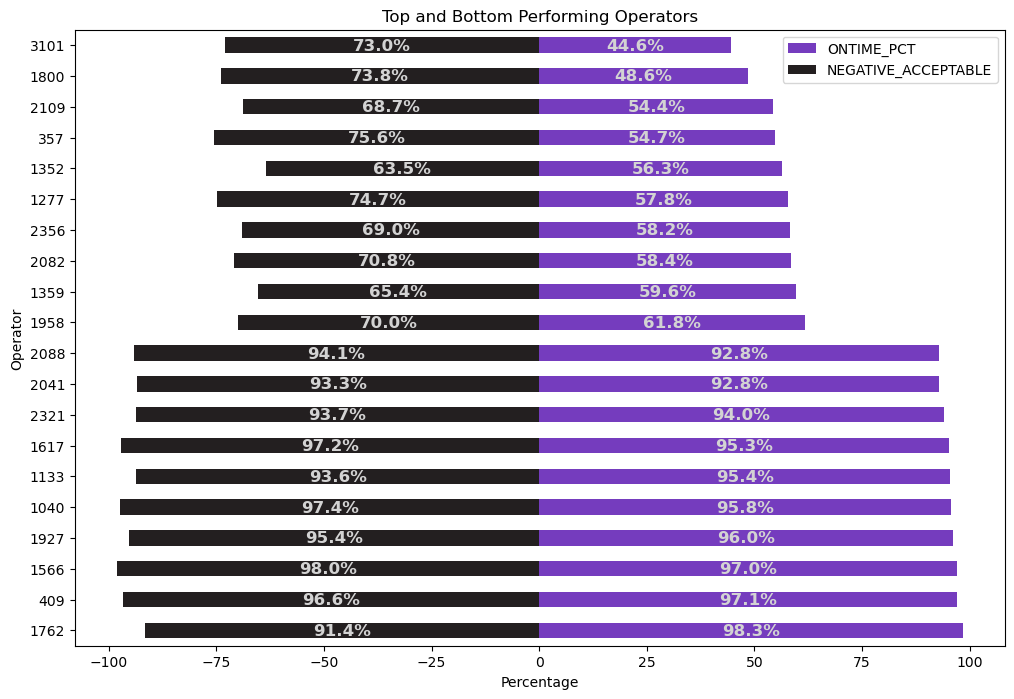

In [172]:
ax = top_bottom_operators[['ONTIME_PCT', 'NEGATIVE_ACCEPTABLE']].plot(kind='barh', color=[purple,black,gray],
                                                                      stacked=True,
                                                                      figsize=(12, 8))

ax.set(title = 'Top and Bottom Performing Operators',
        xlabel = 'Percentage',
       ylabel = 'Operator')

# set bar labels
pd.options.display.float_format = '${:,.2f}'.format
for bar in ax.patches:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() - 0.41,
      get_label_value(bar.get_width()),
      ha='center',
      color=gray, 
      weight='bold',
      size=12,
  )

In [173]:
# plt.figure(figsize=(8, 6))
# hdwy_operator_total.boxplot(column = ['BUNCHING_PCT','ACCEPTABLE_PCT','GAPPING_PCT'])
# plt.title('Headway Deviation Percentage by Driver')

# plt.show()

# Q5
Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [174]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_GAPPING', 'HDWY_ACCEPTABLE', 'HOUR',
       'DAY_OF_WEEK', 'WEEKDAY', 'WEEK_DAY'],
      dtype='object')

In [175]:
#create a new dataframe for adherence and hdwy_dev
adh_hdwy_dev = wego[['ADHERENCE','ADJUSTED_ONTIME_COUNT','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','HDWY_DEV']]

In [176]:
adh_hdwy_dev

,ADHERENCE,ADJUSTED_ONTIME_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,HDWY_DEV
0,$-2.13,1,0,0,NaN
1,$-2.45,1,0,0,NaN
2,$-0.93,1,0,0,NaN
3,$6.28,1,0,0,NaN
4,$-1.58,1,0,0,NaN
...,...,...,...,...,...
350324,$-8.43,0,0,1,$5.27
350325,$-11.30,0,0,1,NaN
350326,$-4.32,1,0,0,$1.87
350327,$-22.08,0,0,1,$17.50


In [177]:
adh_hdwy_dev = wego[['ADHERENCE','HDWY_DEV']].dropna().reset_index()

In [178]:
adh_hdwy_dev

,index,ADHERENCE,HDWY_DEV
0,7,$-1.72,$2.67
1,8,$-1.92,$1.97
2,9,$-0.18,$-0.48
3,11,$-1.32,$-2.17
4,12,$1.50,$-3.88
...,...,...,...
265888,350320,$-5.90,$6.72
265889,350323,$-8.62,$4.92
265890,350324,$-8.43,$5.27
265891,350326,$-4.32,$1.87


In [179]:
adh_late_hdw_corr =wego[['ADJUSTED_LATE_COUNT','HDWY_DEV']].corr()

In [180]:
adh_late_hdw_corr

,ADJUSTED_LATE_COUNT,HDWY_DEV
ADJUSTED_LATE_COUNT,$1.00,$0.26
HDWY_DEV,$0.26,$1.00


C:\Users\zenas\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1266: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


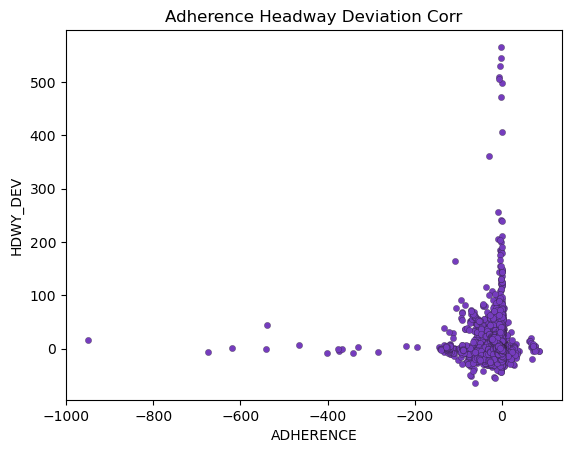

In [204]:
ax = adh_hdwy_dev.plot.scatter(x='ADHERENCE', y='HDWY_DEV', c=purple, edgecolor=black, linewidth=0.2
                               , title = 'Adherence Headway Deviation Corr')
plt.show()



In [206]:
# # PLOT Adherence vs Headway Deviation by category
# plt.figure(figsize=(12,10))

# # EARLY
# plt.scatter(wego.loc[wego['ADJUSTED_EARLY_COUNT'] == 1]['ADHERENCE'],
#             wego.loc[wego['ADJUSTED_EARLY_COUNT'] == 1]['HDWY_DEV'],
#            c = colors['blu'],
#            edgecolor = colors['b'],
#            alpha=0.4)

# # LATE
# plt.scatter(wego.loc[wego['ADJUSTED_LATE_COUNT'] == 1]['ADHERENCE'],
#             wego.loc[wego['ADJUSTED_LATE_COUNT'] == 1]['HDWY_DEV'],
#            c = colors['r'],
#            edgecolor = colors['b'],
#            alpha=0.4)

# # ONTIME
# plt.scatter(wego.loc[wego['ADJUSTED_ONTIME_COUNT'] == 1]['ADHERENCE'],
#             wego.loc[wego['ADJUSTED_ONTIME_COUNT'] == 1]['HDWY_DEV'],
#            c = colors['p'],
#             edgecolor=colors['b'],
#            alpha=0.4)

# plt.xticks(range(-1000, 101, 100))
# plt.yticks(range(-100, 601, 50))

# plt.title('Adherence vs. Headway Deviation (By Category)')
# plt.xlabel('Adherence')
# plt.ylabel('Headway Deviation')
# plt.legend(bbox_to_anchor=(0.13, 1), title='Categories', labels = ['Early', 'Late', 'Ontime'])

# # plt.savefig('../graphs/Adherence-vs-Headway-Deviation-Cat')







